#### A look at the Stackoverflow survey data from year 2020



In this notebook, we are using the data from the [Stackoverflow data - 2020 survey.](https://insights.stackoverflow.com/survey)
<p>
Specifically, we are interested in answering the 3 following questions:
<ol>
<li>What are the top paying languages?</li>
<li>What are the top paying positions?</li>
<li>What factors are important while chosing a job, other than salary and location?</li>
</ol>
</p>
<p>
Run the cell below to get an overview of the questions included in the survey.
</p>

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import CleanAndCount as t

#%matplotlib inline

df = pd.read_csv('stackoverflow_survey_results_public_2020.csv')
schema = pd.read_csv('stackoverflow_survey_results_schema_2020.csv')
schema

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,MainBranch,Which of the following options best describes ...
2,Hobbyist,Do you code as a hobby?
3,Age,What is your age (in years)? If you prefer not...
4,Age1stCode,At what age did you write your first line of c...
5,CompFreq,"Is that compensation weekly, monthly, or yearly?"
6,CompTotal,What is your current total compensation (salar...
7,ConvertedComp,Salary converted to annual USD salaries using ...
8,Country,Where do you live?
9,CurrencyDesc,Which currency do you use day-to-day? If your ...


#### Question 1

**Top paying languages**

**1a.** How is salary related to the language the developer is working with? For this analysis, we consider full-time  professionals working either company employees or as free-lancers.
First we define the functions to use for processing the data.

In [20]:
def filter_employment(df, mask_ls):
    '''
    INPUT 
        df - a dataframe holding the Employment column
        mask_ls - a list holding the emplyment values to filter for
        
    OUTPUT
        df - a dataframe with the filtered rows as per the values defined in the mask
        '''
    
    mask = df['Employment'].isin(mask_ls)   
    return df[mask]



def expand_cat_column(df, column):
    '''
    INPUT
        df - a dataframe holding at least one categorical column
        column - a string holding the name of the categorical column to expand
        
    OUTPUT
        df - the original dataframe with the expanded categorical column
        df_cat - the dataframe containing only the expanded columns
    
    '''
    
    df[column] = df[column].str.split(';')
    df_cat = pd.get_dummies(df[column].apply(pd.Series).stack()).sum(level=0)
    df = pd.concat([df.drop(column, axis=1), df_cat], axis=1)
    return df, df_cat


def map_salary(df_salary, df_ones):
    '''
    INPUT 
        df_salary - a dataframe containing a column with salary data
        df_ones - a column with 0 or 1s, indicating whether salary information shall be mapped or not in the given row
    OUTPUT 
        df - a dataframe with the mapped salary values
    
    '''
    
    mul = lambda col: col * df_salary
    df = df_ones.apply(mul)
    return df


def convert_to_fulltime(df_workhours, df_filtered_cols):
    '''
    INPUT
        df_workhours - a dataframe with the column WorkWeekHrs
        df_filtered_cols - a dataframe containing only columns with salary data
     
    OUTPUT
        df - a dataframe with the converted salary to 40hrs/week
     
     '''
    
    df = 40 *df_filtered_cols.div(df_workhours, axis=0)
    return df


def create_df_with_agg_values(df):
    '''
    INPUT
        df - a dataframe with columns containing salary values
     
    OUTPUT
        df_agg - a new dataframe containing mean, standard deviation and number of counts for each column of the input dataframe 
    '''
        
    mask = df != 0 
    df_agg_mean = df[mask].median()
    df_agg_std = df[mask].std()
    df_agg_counts = df[mask].count()

    df_agg = pd.concat([df_agg_mean, df_agg_std, df_agg_counts], axis=1)
    df_agg = df_agg.rename(columns={0:'Median yearly compensation', 1:'Std compensation', 2:'Counts'})
    df_agg = df_agg.sort_values(by = ['Median yearly compensation'], ascending= True)
    return df_agg


def calculate_salary_per_category(df, cat_column):
    '''
    INPUT
        df - a dataframe with the column WorkWeekHrs, ConvertedComp, and a column with categorical values
        cat_column - a categorical column for each value of which we want to calculate the salary
    OUTPUT
        df_agg_results - a new dataframe containing median, standard deviation and number of counts for each column of the expandecategorical values 
     '''
    
    df_expand, df_cat = expand_cat_column(df, cat_column)
    df_salary = map_salary(df_expand['ConvertedComp'], df_cat)
    df_full_time = convert_to_fulltime(df['WorkWeekHrs'], df_salary)
    df_agg_results = create_df_with_agg_values(df_full_time)
    return df_agg_results


Start by selecting the columns of interest and remove NA values from the columns ConvertedComp, LanguageWorkedWith, and LanguageWorkedWith.

In [21]:
df_fil = df[['LanguageWorkedWith', 'ConvertedComp', 'WorkWeekHrs', 'Employment']]
df_fil = df_fil.dropna(subset=['ConvertedComp', 'LanguageWorkedWith', 'LanguageWorkedWith'], axis=0)
df_fil = df_fil.reset_index()

First we are checking the results only for full-time employees. We are using a mask to filter for the rows with 'Employed full-time' values.

In [22]:
employment_mask = ['Employed full-time']
#mask = ['Employed full-time', 'Independent contractor, freelancer, or self-employed']

df_fil = filter_employment(df_fil, employment_mask)
df_agg_full_time = calculate_salary_per_category(df_fil, 'LanguageWorkedWith')

Plot the results using a barplot.

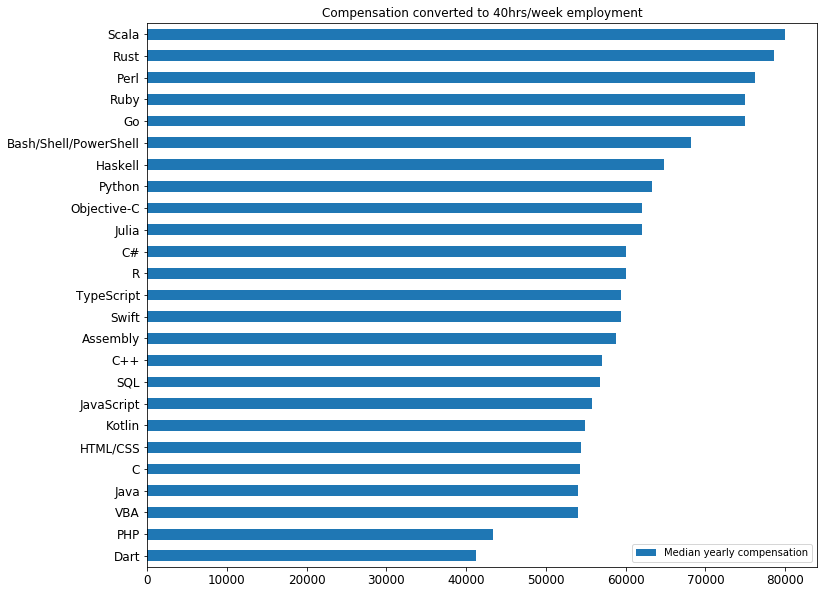

In [23]:
ax = df_agg_full_time[['Median yearly compensation']].plot(kind='barh', title ="Compensation converted to 40hrs/week employment", figsize=(12, 10), legend=True, fontsize=12)

We are using a mask to filter for the rows with 'Independent contractor, freelancer, or self-employed' values.

In [24]:
df_fil = df[['LanguageWorkedWith', 'DevType', 'ConvertedComp', 'JobSat', 'WorkWeekHrs', 'Employment']]
df_fil = df_fil.dropna(subset=['ConvertedComp', 'LanguageWorkedWith', 'WorkWeekHrs'], axis=0)
df_fil = df_fil.reset_index()

In [25]:
employment_mask = ['Independent contractor, freelancer, or self-employed']

df_fil = filter_employment(df_fil, employment_mask)
df_agg_freelancer = calculate_salary_per_category(df_fil, 'LanguageWorkedWith')

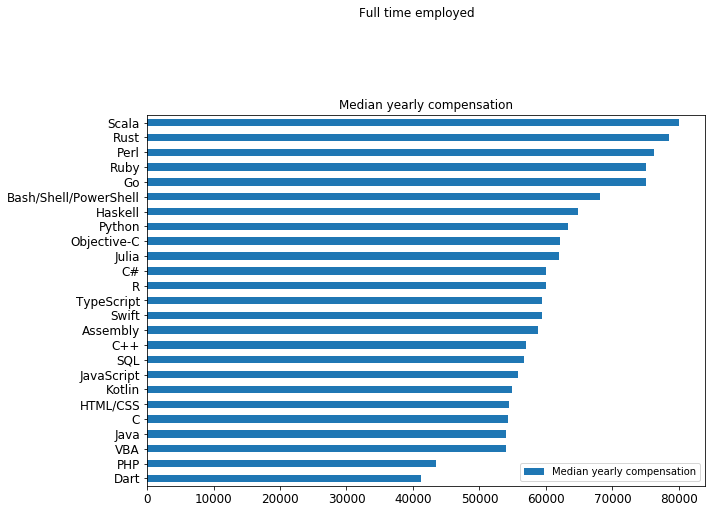

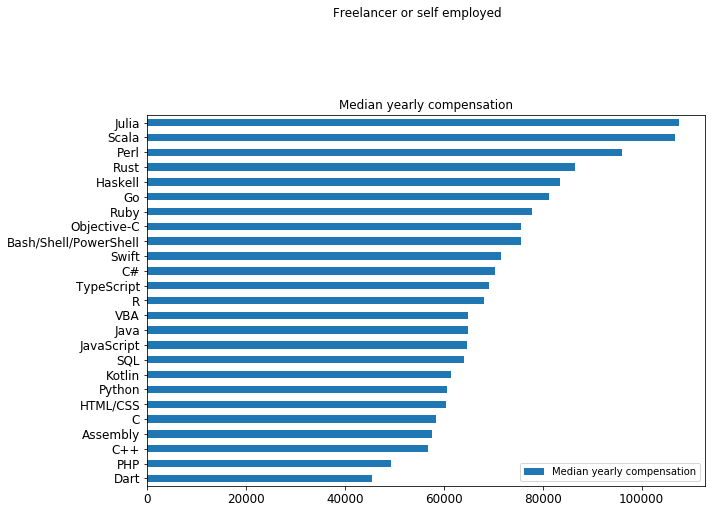

In [26]:
combined = df_agg_full_time.append(df_agg_freelancer)
#combined[['Average compensation']].plot(kind='barh', title ="Salary converted to 40hrs/week employment", figsize=(15, 10), legend=True, fontsize=12)

axes = df_agg_full_time[['Median yearly compensation']].plot( subplots=True, layout=(2,1), kind='barh', title ="Full time employed", figsize=(10, 15), legend=True, fontsize=12)
axes = df_agg_freelancer[['Median yearly compensation']].plot(subplots=True, layout=(2,1), kind='barh', title ="Freelancer or self employed", figsize=(10, 15), legend=True, fontsize=12)


**1b.** What is the difference between free-lancers and full-time company employees? Below we investigate the impact the employment type has on the salary per each category.

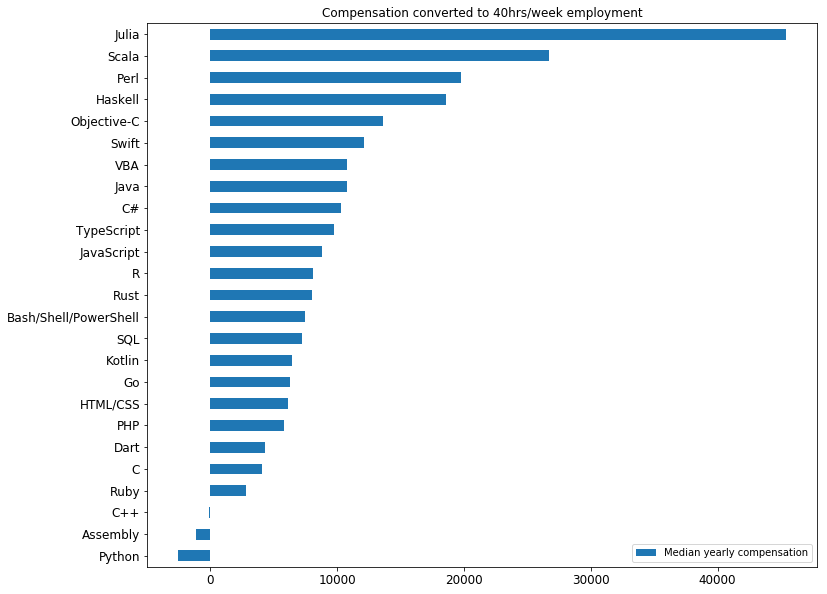

In [27]:
df_diff= (df_agg_freelancer - df_agg_full_time).sort_values(by = ['Median yearly compensation'], ascending= True)

ax = df_diff[['Median yearly compensation']].plot(kind='barh', title ="Compensation converted to 40hrs/week employment", figsize=(12, 10), legend=True, fontsize=12)

In [28]:
df_diff.sort_values(by = ['Median yearly compensation'], ascending= False).style.bar(subset=['Median yearly compensation'], align='mid', color=['#d65f5f', '#5fba7d'])

,Median yearly compensation,Std compensation,Counts
Julia,45421.9,-48926.8,-156
Scala,26727.3,54660,-926
Perl,19805.3,-171905,-646
Haskell,18609,-5157.13,-323
Objective-C,13620.4,-211307,-809
Swift,12077.3,-261945,-1162
VBA,10811,-3888.69,-1236
Java,10810,1.17676e+06,-8027
C#,10326.3,-136785,-7322
TypeScript,9728.86,-74949.1,-6371


**1c.** We are checking alternative ways to plot the results, so that the reuslts are presented on the blogpost.
Below we are using a fancy polar plot.

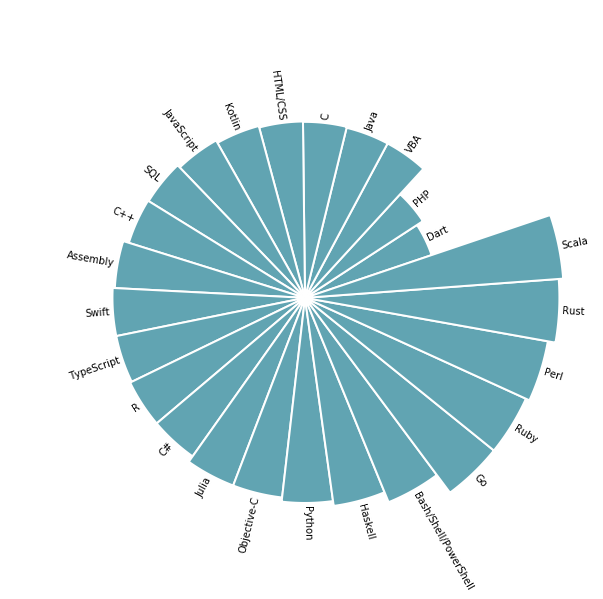

In [29]:
#Code for a nice polar plot creation. Source: https://www.python-graph-gallery.com/

# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 120
lowerLimit = 30
labelPadding = 1000

# Compute max and min in the dataset
max = df_agg_full_time['Median yearly compensation'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df_agg_full_time['Median yearly compensation'] + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df_agg_full_time.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df_agg_full_time.index)+1))
angles = [element * width +0.2 for element in indexes]


# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color="#61a4b2",
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df_agg_full_time.index):
    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 
    
plt.savefig('Salary_vs_language_polar.png')

**1d.** Further, we want to investigate how is does it make sense to learn a new language. We group the results for learning frequency and calculate the median salary.

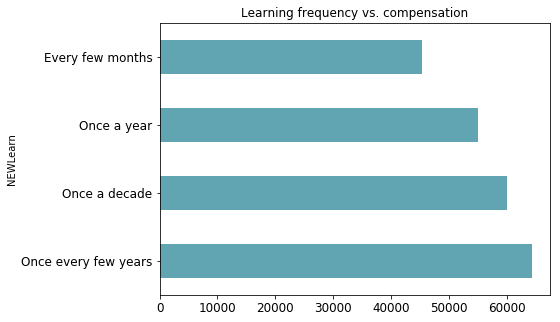

In [30]:
df1 = df[['NEWLearn','ConvertedComp',  'Employment']].dropna()

df1 = df1.groupby('NEWLearn').median().sort_values(by='ConvertedComp', ascending=False)

fig = df1.plot(kind="barh", legend=None, color='#61a4b2', figsize=(7,5), fontsize=12)
plt.title("Learning frequency vs. compensation")
#plt.box('off')

plt.savefig('Salary_vs_language_polar.png')

#### Question 2
**Top paying developer jobs**

**2a.** How is salary related to the job position of the developer?. To answer this question, we use again the function calculate_salary_per_category to calculate the median salary per each developer job category.

In [31]:
df_fil = df[['LanguageWorkedWith', 'DevType', 'ConvertedComp', 'JobSat', 'WorkWeekHrs', 'Employment']]
df_fil = df_fil.dropna(subset=['ConvertedComp', 'DevType', 'WorkWeekHrs'], axis=0)
df_fil = df_fil.reset_index()

In [32]:
devtype_mask = ['Employed full-time', 'Independent contractor, freelancer, or self-employed']
df_fil = filter_employment(df_fil, devtype_mask)

df_agg = calculate_salary_per_category(df_fil, 'DevType')

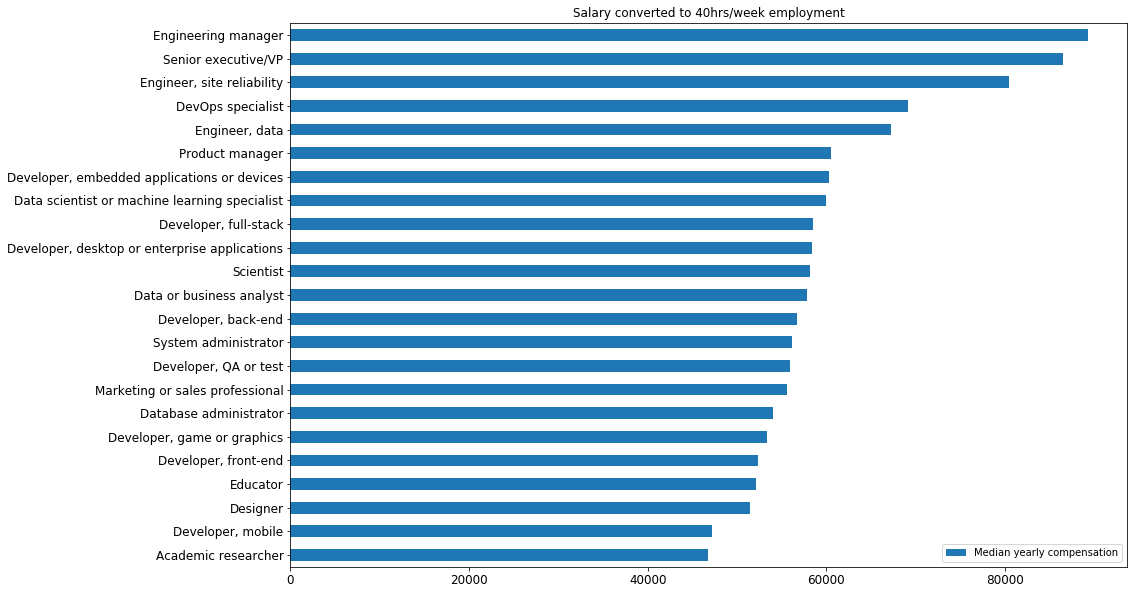

In [33]:
ax = df_agg[['Median yearly compensation']].plot(kind='barh', title ="Salary converted to 40hrs/week employment", figsize=(15, 10), legend=True, fontsize=12)

#### Question 3
**Job selection factors**

**3a.** How is salary related to the job position of the developer?

Specifically, survey is asking the question: ''Imagine that you are deciding between two job offers with the same compensation, benefits, and location. Of the following factors, which 3 are MOST important to you?''

Because multiple values are allowed as a reply, we are using the function clean_and_plot to separate each possible replies and plot the results.

                                                       count
method                                                      
Diversity of the company or organization            0.022323
Specific department or team I’d be working on       0.040474
Financial performance or funding status of the ...  0.040637
Family friendliness                                 0.041444
Industry that I’d be working in                     0.051914
How widely used or impactful my work output wou...  0.070864
Remote work options                                 0.113097
Opportunities for professional development          0.139488
Flex time or a flexible schedule                    0.150593
Office environment or company culture               0.153391
Languages, frameworks, and other technologies I...  0.175774


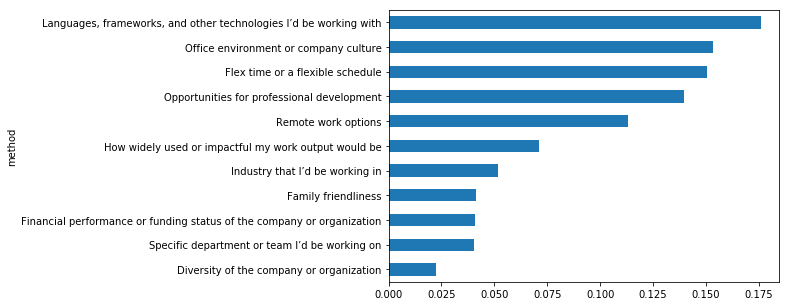

In [34]:
possible_vals = ['Remote work options', 'Office environment or company culture',
                'Financial performance or funding status of the company or organization',
                'Opportunities for professional development',
                'Diversity of the company or organization',
                'How widely used or impactful my work output would be',
                'Industry that I’d be working in',
                'Specific department or team I’d be working on',
                'Flex time or a flexible schedule',
                'Languages, frameworks, and other technologies I’d be working with',
                'Family friendliness']

props_df = t.clean_and_plot(df, 'JobFactors', possible_vals)
#title='Job selection factors'

**b.** Here we want to learn which are the main sources used by the developers to get informed over a potential employer. 

Specifically, survey is asking the question:'When job searching, how do you learn more about a company? Select all that apply.'

We are using again the function clean_and_plot to, because multiple answers are possible by each respondent.

                                                       count
method                                                      
Publicly available financial information (e.g. ...  0.084927
Directly asking current or past employees at th...  0.117039
Read other media like news articles, founder pr...  0.158634
Personal network - friends or family                0.204387
Read company media, such as employee blogs or c...  0.209886
Company reviews from third party sites (e.g. Gl...  0.225127


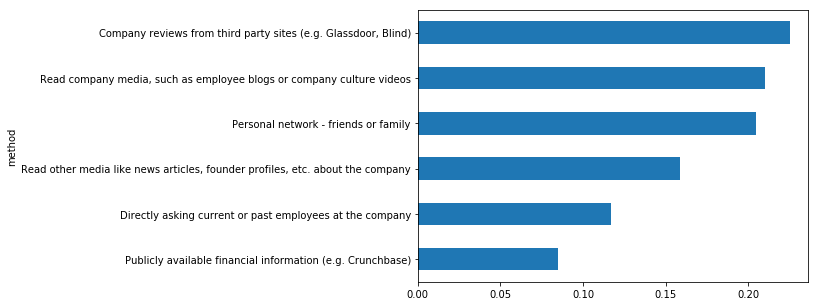

In [35]:
possible_vals = ['Read company media, such as employee blogs or company culture videos',
                'Company reviews from third party sites (e.g. Glassdoor, Blind)',
                'Publicly available financial information (e.g. Crunchbase)',
                'Personal network - friends or family',
                'Read other media like news articles, founder profiles, etc. about the company',
                'Directly asking current or past employees at the company']

props_df = t.clean_and_plot(df, 'NEWJobHuntResearch', possible_vals)
#title='How do you learn more about a company when job searching'

## Question 4 
**Conclusion - Drives for searching for a new job**

As a final step, we want to have a look at the main reasons driving someone to start searching for a new job. In this case also, we are using the function clean_and_plot to process the multiple answers present in each row.

                                                       count
method                                                      
Wanting to share accomplishments with a wider n...  0.024477
Trouble with my teammates                           0.028684
Just because                                        0.029788
Trouble with my direct manager                      0.041882
Having a bad day (or week or month) at work         0.049509
Looking to relocate                                 0.064129
Trouble with leadership at my company               0.065923
Better work/life balance                            0.117198
Growth or leadership opportunities                  0.128187
Curious about other opportunities                   0.138677
Wanting to work with new technologies               0.141175
Better compensation                                 0.170372


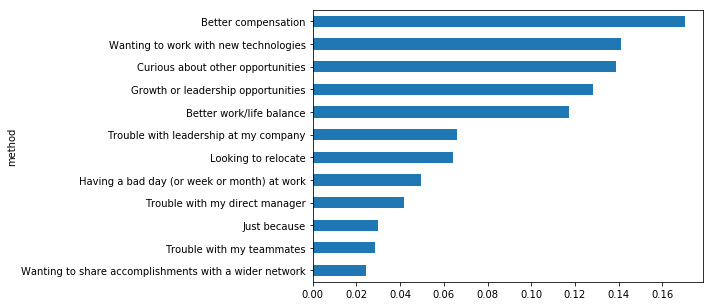

In [36]:
possible_vals = ['Just because',
                'Having a bad day (or week or month) at work',
                'Wanting to share accomplishments with a wider network',
                'Curious about other opportunities',
                'Better compensation',
                'Trouble with my teammates',
                'Trouble with my direct manager',
                'Trouble with leadership at my company',  
                 'Better work/life balance',
                'Wanting to work with new technologies',
                'Growth or leadership opportunities',
                'Looking to relocate']
df1 = df.dropna(subset=['NEWJobHunt'])

props_df = t.clean_and_plot(df1, 'NEWJobHunt', possible_vals)